In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install torch
!pip install torchvision

In [8]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [10]:
DATA_DIR = '/kaggle/input/'/kaggle/input/flickrfaceshq-dataset-ffhq
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
print(os.listdir(DATA_DIR+'flickrfaceshq-dataset-ffhq')[:10])

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/flickrfaceshq-dataset-ffhq'

In [5]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
 
  train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [6]:
image_size = 64
batch_size = 64

#TODO: build dataloader and transfer it to device
train_dl = get_dataloader(image_size, batch_size)

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

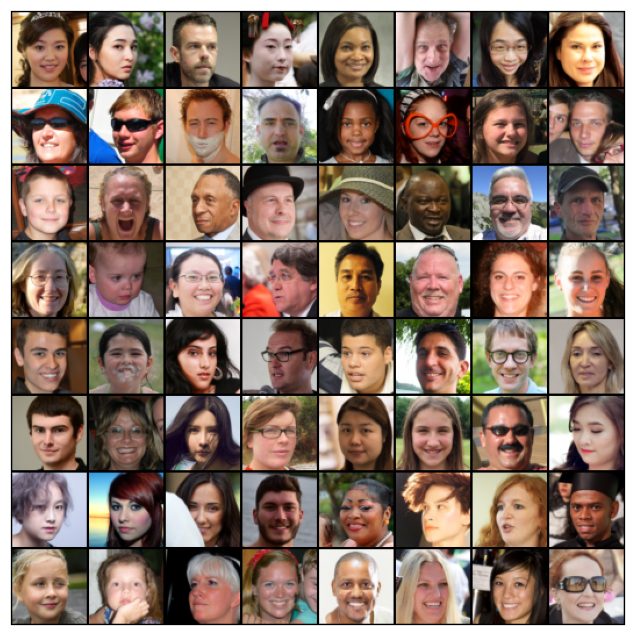

In [9]:
show_batch(train_dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([64, 3, 64, 64])
64


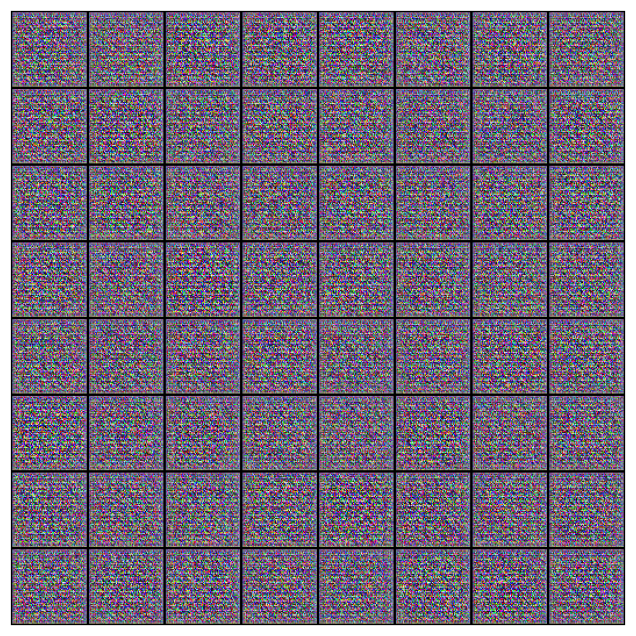

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
generator = to_device(generator, torch.device('cpu'))
fake_images = generator(xb)
print(fake_images.shape)
print(batch_size)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


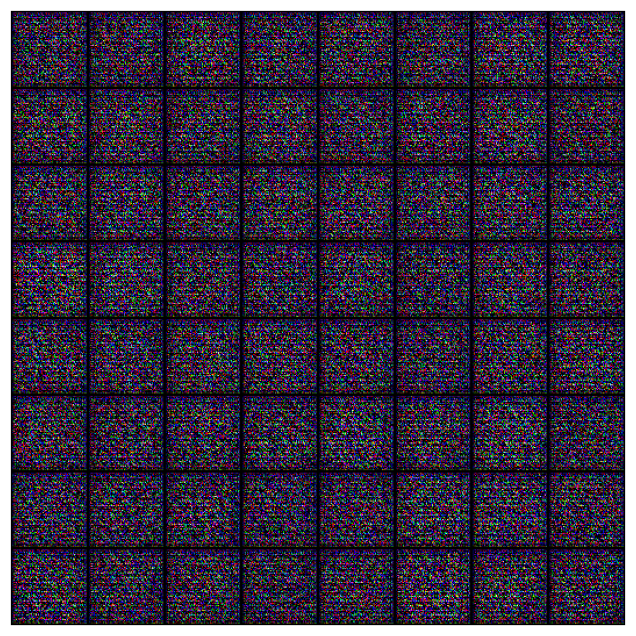

In [25]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 25

In [28]:
history = fit(epochs, lr)

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.9789, loss_d: 0.5038, real_score: 0.8258, fake_score: 0.2060
Saving generated-images-0001.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.0833, loss_d: 0.4335, real_score: 0.7906, fake_score: 0.1205
Saving generated-images-0002.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.4029, loss_d: 0.1658, real_score: 0.9056, fake_score: 0.0553
Saving generated-images-0003.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.4824, loss_d: 0.3098, real_score: 0.9134, fake_score: 0.1674
Saving generated-images-0004.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.9026, loss_d: 0.9964, real_score: 0.9865, fake_score: 0.5261
Saving generated-images-0005.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.0524, loss_d: 0.2635, real_score: 0.9732, fake_score: 0.1950
Saving generated-images-0006.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 2.4359, loss_d: 0.2484, real_score: 0.8575, fake_score: 0.0719
Saving generated-images-0007.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 4.2547, loss_d: 0.2259, real_score: 0.9491, fake_score: 0.1402
Saving generated-images-0008.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.3874, loss_d: 0.1125, real_score: 0.9921, fake_score: 0.0941
Saving generated-images-0009.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 3.6008, loss_d: 0.2259, real_score: 0.9375, fake_score: 0.1340
Saving generated-images-0010.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 0.1361, loss_d: 1.5373, real_score: 0.3398, fake_score: 0.0006
Saving generated-images-0011.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.8857, loss_d: 0.3261, real_score: 0.8114, fake_score: 0.0864
Saving generated-images-0012.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 2.5056, loss_d: 3.1333, real_score: 0.0953, fake_score: 0.0001
Saving generated-images-0013.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.7503, loss_d: 0.0703, real_score: 0.9464, fake_score: 0.0110
Saving generated-images-0014.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.6941, loss_d: 0.1470, real_score: 0.8937, fake_score: 0.0234
Saving generated-images-0015.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.1199, loss_d: 0.3900, real_score: 0.8071, fake_score: 0.0905
Saving generated-images-0016.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 1.8824, loss_d: 0.2311, real_score: 0.8534, fake_score: 0.0446
Saving generated-images-0017.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.9753, loss_d: 0.1823, real_score: 0.9161, fake_score: 0.0725
Saving generated-images-0018.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.8200, loss_d: 0.0677, real_score: 0.9840, fake_score: 0.0464
Saving generated-images-0019.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 0.9396, loss_d: 0.6549, real_score: 0.6010, fake_score: 0.0057
Saving generated-images-0020.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.8817, loss_d: 0.1419, real_score: 0.9887, fake_score: 0.1066
Saving generated-images-0021.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.5733, loss_d: 0.1752, real_score: 0.9483, fake_score: 0.0973
Saving generated-images-0022.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.1220, loss_d: 0.1305, real_score: 0.9558, fake_score: 0.0712
Saving generated-images-0023.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 3.3177, loss_d: 0.2404, real_score: 0.8608, fake_score: 0.0409
Saving generated-images-0024.png


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 3.2601, loss_d: 0.1221, real_score: 0.9199, fake_score: 0.0287
Saving generated-images-0025.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

In [30]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [31]:
from IPython.display import Image

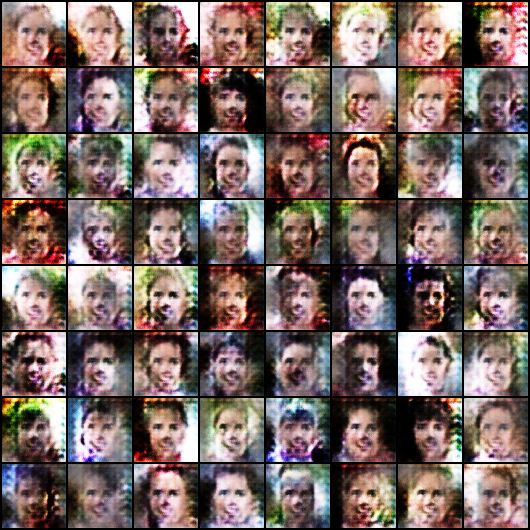

In [32]:
Image('./generated/generated-images-0001.png')

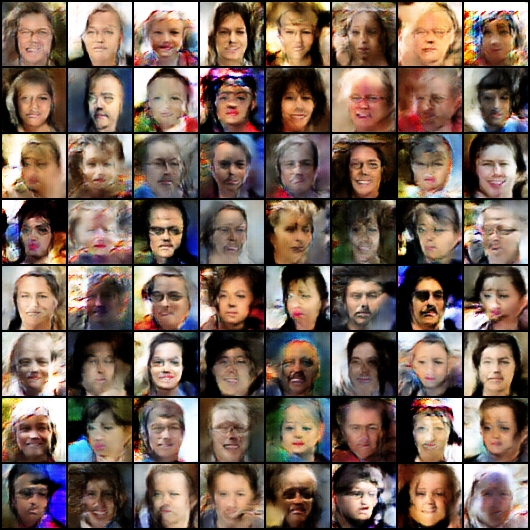

In [33]:
Image('./generated/generated-images-0005.png')

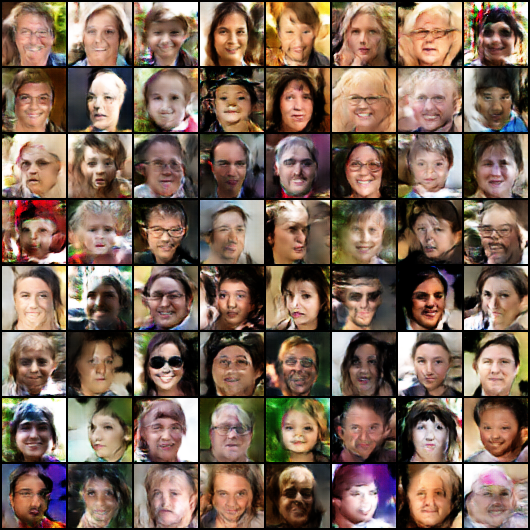

In [34]:
Image('./generated/generated-images-0010.png')

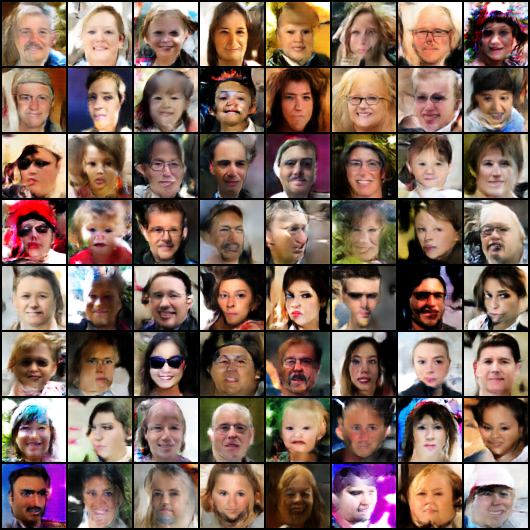

In [35]:
Image('./generated/generated-images-0020.png')

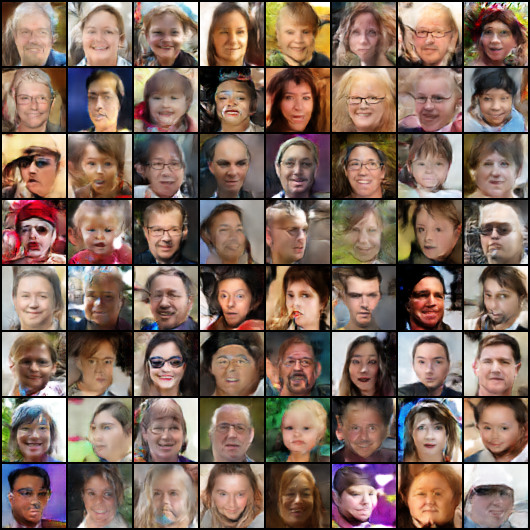

In [36]:
Image('./generated/generated-images-0025.png')

In [37]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


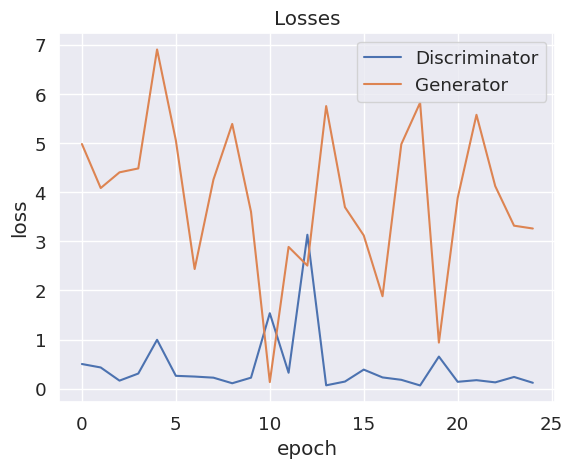

In [38]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

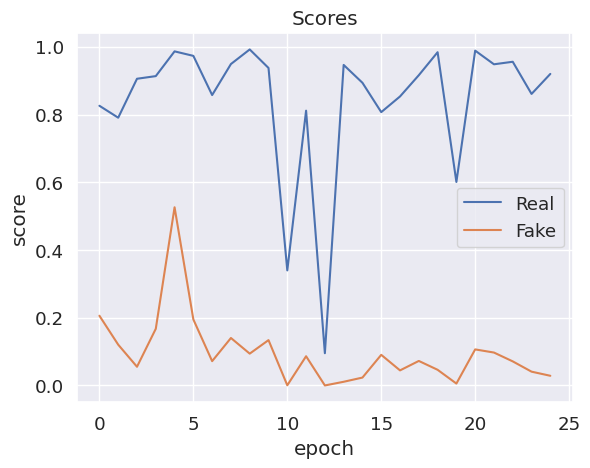

In [39]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');